# Automatic classification of eclipsing binary stars using deep learning methods

> Vstupne datasety (single_spotty.pkl, overcontact_bellow_i_crit.pkl, detached_bellow_i_crit_10000) boli vytvorene pomocou binaries_single_spotty.ipynb, binaries_overcontact_bellow_i_crit_10000.ipynb, binaries_detached_bellow_i_crit_10000.ipynb

Experiment 6


- datasety: single spotty (6 853)
              overcontact_bellow_i_crit (10 000)
              detached_bellow_i_crit (10 000)
- vstup do modelu: krivky (BRUVI) spojene do jedneho datasetu
- šum: stochastic_noise_generator, curve_alignement
- train_test_split: test_size=0.2
- výstup modelu: klasifikacia 0 -> single spotty, 
                            1 -> binary star (overcontact + detached)
- evaluácia: krivky (BRUVI) spojene do jedneho datasetu, nad 0.4 -> 1
- checkpoint: monitor: val_loss, mode: min


In [1]:
import numpy as np
import pandas as pd
import json
import pickle
np.random.seed(1234)

from noise_generator import stochastic_noise_generator
from curve_alignement import curve_alignement_randomizer
from sklearn.model_selection import train_test_split


from keras.utils import np_utils
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split

from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, SpatialDropout1D, GlobalAveragePooling1D
from keras.layers import Input, Dense, concatenate, Activation, LSTM, Bidirectional, Flatten, Dropout
from keras.models import Model
from keras.models import Sequential
from keras.layers.merge import Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

import imblearn
from imblearn import under_sampling, over_sampling
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

import scikitplot as skplt

In [2]:
# V pripade ak boli chyby s importami, tak je potrebne to spustit (robi sa so zdielanymi prostrediami)

# %pip install keras
# %pip install elisa
# %pip install imblearn
# %pip install --upgrade tensorflow
# %pip install --upgrade tensorflow-gpu
# %pip install scikit-plot

## Data load

- load synthetic light curve - ELISa
- Loads previously prepared data,

In [3]:
data_single_spotty_0 = pd.read_pickle("single_spotty.pkl")
data_single_spotty_0.head(1)

,id,Bessell_U,Bessell_B,Bessell_V,Bessell_R,Bessell_I,overcontact
0,1,"[0.999723147256461, 0.9998263845312357, 0.9999...","[0.999729147335103, 0.9998341245757354, 0.9999...","[0.9997193606202365, 0.9998297654831404, 0.999...","[0.9997101293497717, 0.9998251315085762, 0.999...","[0.9996999473946334, 0.9998205539859434, 0.999...",0


In [4]:
data_overcontact_1 = pd.read_pickle("overcontact_bellow_i_crit.pkl")
data_overcontact_1.head(1)

,id,Bessell_U,Bessell_B,Bessell_V,Bessell_R,Bessell_I,overcontact
0,5523148,"[1.0, 0.9999997307325279, 0.9999993208745404, ...","[1.0, 0.9999997333725458, 0.9999993854857628, ...","[1.0, 0.9999997522458502, 0.9999994904106757, ...","[1.0, 0.9999997580790063, 0.9999995484215244, ...","[1.0, 0.9999997080162979, 0.9999995299493861, ...",1


In [5]:
data_detached_1 = pd.read_pickle("detached_bellow_i_crit_10000.pkl")
data_detached_1['overcontact'].values[:] = 1
data_detached_1.head(1)

,id,Bessell_U,Bessell_B,Bessell_V,Bessell_R,Bessell_I,overcontact
0,16475486,"[0.9725785101533405, 0.9725670857905166, 0.972...","[0.9492919880946644, 0.9492817827705917, 0.949...","[0.9453769164275371, 0.9453675090288542, 0.945...","[0.9471419755249144, 0.9471329680009939, 0.947...","[0.9493361170990322, 0.9493283389169975, 0.949...",1


In [6]:
data_overcontact_1 = data_overcontact_1.sample(n = 10000, random_state=123)

In [7]:
data_overcontact_1.head(10)

,id,Bessell_U,Bessell_B,Bessell_V,Bessell_R,Bessell_I,overcontact
37323,63727918,"[0.8496147144074915, 0.8496480809117025, 0.849...","[0.8513613644692577, 0.8513939929255343, 0.851...","[0.86186395266733, 0.8618923229018682, 0.86198...","[0.8674806339484662, 0.8675066927985281, 0.867...","[0.8731602566876797, 0.8731839445156725, 0.873...",1
45861,71164710,"[0.8682432495086728, 0.8682712691426288, 0.868...","[0.8624249332014946, 0.8624549209771928, 0.862...","[0.8703230212194507, 0.8703501643057973, 0.870...","[0.8766116052401189, 0.8766365165424321, 0.876...","[0.8838795097697446, 0.8839019033442411, 0.883...",1
26272,49705868,"[0.995664982202667, 0.9956659797301951, 0.9956...","[0.9958972464717006, 0.9958981080884609, 0.995...","[0.9963357952754733, 0.9963364856754854, 0.996...","[0.9966921515158839, 0.9966927158074816, 0.996...","[0.9969371014117936, 0.9969375470471336, 0.996...",1
39847,64366719,"[0.8016853955793815, 0.8017402516556926, 0.801...","[0.7963095256253208, 0.7963652946421432, 0.796...","[0.8045022381555672, 0.8045566751288011, 0.804...","[0.8124582197781418, 0.8125115043340678, 0.812...","[0.8228323004538204, 0.822884001684067, 0.8230...",1
3348,12746829,"[0.860564709506529, 0.8605940814813549, 0.8606...","[0.8723296647423305, 0.8723559140101012, 0.872...","[0.8831341620809866, 0.8831579342429802, 0.883...","[0.8894875426286579, 0.8895100914788445, 0.889...","[0.8959685845516996, 0.8959898825241, 0.896054...",1
43679,70734573,"[0.6928170188138121, 0.6929100423017178, 0.693...","[0.6984349511086686, 0.6985284454810091, 0.698...","[0.7127118392888472, 0.7128077538411635, 0.713...","[0.7241150624987043, 0.7242116913431497, 0.724...","[0.7515828922567859, 0.7516770841437277, 0.751...",1
11641,33987146,"[0.947275521517375, 0.9472892225697008, 0.9473...","[0.9461400030185586, 0.9461553762089685, 0.946...","[0.9467239952769816, 0.94674209440269, 0.94678...","[0.9476970565394248, 0.947716979898178, 0.9477...","[0.9502351795043076, 0.9502572711815299, 0.950...",1
39984,64574178,"[0.7615939373746348, 0.7616498591291624, 0.761...","[0.7633440113954898, 0.763399974838947, 0.7635...","[0.7796763341091232, 0.7797301738573585, 0.779...","[0.7905655377074924, 0.7906177150147418, 0.790...","[0.8128274881043589, 0.8128746998750678, 0.813...",1
37622,63730196,"[0.9886329741296338, 0.9886361985326815, 0.988...","[0.9876852470442434, 0.9876886138004548, 0.987...","[0.9881627006029201, 0.9881659830405556, 0.988...","[0.988699927347837, 0.9887031236147049, 0.9887...","[0.98936830304316, 0.9893713857254326, 0.98937...",1
16716,41213424,"[0.783122894260451, 0.7831914242755483, 0.7833...","[0.7757129466849731, 0.7757836087191429, 0.775...","[0.7892886661954656, 0.7893562754761582, 0.789...","[0.7978703809962698, 0.7979360138788693, 0.798...","[0.8072209053982318, 0.8072845100270818, 0.807...",1


In [8]:
data_overcontact_1= pd.DataFrame(curve_alignement_randomizer(data_overcontact_1), 
                                 columns=['id', 'Bessell_U',  'Bessell_B',  'Bessell_V',  'Bessell_R',  'Bessell_I',  'overcontact'])

In [9]:
data_detached_1= pd.DataFrame(curve_alignement_randomizer(data_overcontact_1), 
                                 columns=['id', 'Bessell_U',  'Bessell_B',  'Bessell_V',  'Bessell_R',  'Bessell_I',  'overcontact'])

In [10]:
data = pd.concat([data_single_spotty_0, data_overcontact_1, data_detached_1])
data.head(2)

,id,Bessell_U,Bessell_B,Bessell_V,Bessell_R,Bessell_I,overcontact
0,1,"[0.999723147256461, 0.9998263845312357, 0.9999...","[0.999729147335103, 0.9998341245757354, 0.9999...","[0.9997193606202365, 0.9998297654831404, 0.999...","[0.9997101293497717, 0.9998251315085762, 0.999...","[0.9996999473946334, 0.9998205539859434, 0.999...",0
1,2,"[0.999723147256461, 0.9998263845312357, 0.9999...","[0.999729147335103, 0.9998341245757354, 0.9999...","[0.9997193606202365, 0.9998297654831404, 0.999...","[0.9997101293497717, 0.9998251315085762, 0.999...","[0.9996999473946334, 0.9998205539859434, 0.999...",0


In [11]:
data.tail(2)

,id,Bessell_U,Bessell_B,Bessell_V,Bessell_R,Bessell_I,overcontact
9998,56929884,"[0.8057866175789103, 0.8058286046255967, 0.805...","[0.8151740714714587, 0.8152120540702733, 0.815...","[0.8303655260065497, 0.8303968118544228, 0.830...","[0.8382249515195537, 0.838252716593947, 0.8383...","[0.8460589836812665, 0.8460832443110399, 0.846...",1
9999,42058203,"[0.8851616170852903, 0.885188975515422, 0.8852...","[0.8827427103881559, 0.8827705805121983, 0.882...","[0.8886051667272032, 0.8886328499002399, 0.888...","[0.8933496955222048, 0.8933769815273436, 0.893...","[0.9067108251193662, 0.906736094549957, 0.9068...",1


### Check data 

In [12]:

data["id"] = data["id"].astype(int)
data["overcontact"] = data["overcontact"].astype(int)

In [13]:
data.dtypes

id              int64
Bessell_U      object
Bessell_B      object
Bessell_V      object
Bessell_R      object
Bessell_I      object
overcontact     int64
dtype: object

In [14]:
data['overcontact'].value_counts()

1    20000
0     6853
Name: overcontact, dtype: int64

## Data preparation
- train_test_split
- bessel_to_array -> comma seperated string transforms to array
- add noice to train and test sets
> musi to byt v tomto poradi lebo ked sa aplikuje noice tak uz nejde urobit train_test_split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(data, data['overcontact'], test_size=0.2, random_state=42)

# Check shapes after split
print(X_train.shape)
print("########")
print(y_train)
print("########")
print(X_test.shape)
print("########")
print(y_test)
print("########")

(21482, 7)
########
8912    1
1966    0
4088    1
628     1
3213    0
       ..
4722    1
5390    0
860     0
8942    1
6801    1
Name: overcontact, Length: 21482, dtype: int64
########
(5371, 7)
########
3136    1
2240    0
5454    1
3096    0
988     1
       ..
2857    1
1321    1
6529    1
7028    1
41      0
Name: overcontact, Length: 5371, dtype: int64
########


In [16]:
def bessel_to_array(column_name, df):
    """Model expects array input. 
    This function transforms all curves in 1 column (400 comma seperated numbers) to array"""
    newData_bessell = []
    for row in df[column_name]:
        newRow = []
        for valueIndex in range(len(row)):
            print([row[valueIndex]])
            newRow.append([row[valueIndex]])
        newData_bessell.append(newRow) 
    newData_bessell = np.array(newData_bessell)
    return newData_bessell

In [17]:
X_train_with_arrays_noise = []
for column in ['Bessell_U','Bessell_B','Bessell_V','Bessell_R','Bessell_I']:
    X_train_with_arrays_noise.append(stochastic_noise_generator(bessel_to_array(column, X_train)))
    print(column + " " + "prossessed")

Bessell_U prossessed
Bessell_B prossessed
Bessell_V prossessed
Bessell_R prossessed
Bessell_I prossessed


In [18]:
X_test_with_arrays_noise = []
for column in ['Bessell_U','Bessell_B','Bessell_V','Bessell_R','Bessell_I']:
    X_test_with_arrays_noise.append(stochastic_noise_generator(bessel_to_array(column, X_test)))
    print(column + " " + "prossessed")

Bessell_U prossessed
Bessell_B prossessed
Bessell_V prossessed
Bessell_R prossessed
Bessell_I prossessed


In [19]:
# (5, 2, 16000, 400, 1) -> meaning: 
# 5 - UBVRI
# 16000 - number of curves
# 400 - size of 1 curve
# 1 - detached or overcontact

print(np.array(X_train_with_arrays_noise).shape)
print(np.array(X_test_with_arrays_noise).shape)

(5, 2, 21482, 400, 1)
(5, 2, 5371, 400, 1)


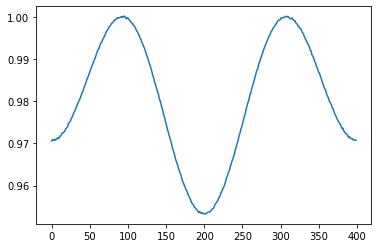

In [20]:
# Check if noice was added successfully
plt.plot(X_train_with_arrays_noise[1][0][1500])

In [21]:
# Check if U,B,V,R,I version of the same curve with noice is different
print(np.array_equal(X_train_with_arrays_noise[0][0], X_train_with_arrays_noise[1][0]))
print(np.array_equal(X_train_with_arrays_noise[1][0], X_train_with_arrays_noise[2][0]))
print(np.array_equal(X_train_with_arrays_noise[2][0], X_train_with_arrays_noise[3][0]))
print(np.array_equal(X_train_with_arrays_noise[3][0], X_train_with_arrays_noise[4][0]))

False
False
False
False


In [22]:
# target is overcontact
target = np.array(y_train)
print(target)

# just to be sure that both types are in dataset
exists = 0 in target
print(exists)
exists = 1 in target
print(exists)

[1 0 1 ... 0 1 1]
True
True


> Control the shape and check if the dataset is imbalanced (ale nacital som si z oboch 10 000 cize viem ze by mal byt vyvazeny)

In [23]:
print(target.shape)

print(X_train_with_arrays_noise[0][0].shape)
print(X_train_with_arrays_noise[1][0].shape)
print(X_train_with_arrays_noise[2][0].shape)
print(X_train_with_arrays_noise[3][0].shape)
print(X_train_with_arrays_noise[4][0].shape)

print(Counter(target))

(21482,)
(21482, 400, 1)
(21482, 400, 1)
(21482, 400, 1)
(21482, 400, 1)
(21482, 400, 1)
Counter({1: 16012, 0: 5470})


    - fit and apply the transform

In [24]:
def print_shape_counter(column, target):
    print(column.shape)
    print(target.shape)
    print(Counter(target))

In [25]:
for i in range(5):
    print_shape_counter(X_train_with_arrays_noise[i][0], y_train)
    print("")

(21482, 400, 1)
(21482,)
Counter({1: 16012, 0: 5470})

(21482, 400, 1)
(21482,)
Counter({1: 16012, 0: 5470})

(21482, 400, 1)
(21482,)
Counter({1: 16012, 0: 5470})

(21482, 400, 1)
(21482,)
Counter({1: 16012, 0: 5470})

(21482, 400, 1)
(21482,)
Counter({1: 16012, 0: 5470})



In [26]:
# transform to categorical
y_train = np_utils.to_categorical(y_train, 2)
y_train

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [27]:
#Check shape 
print(np.array(X_train_with_arrays_noise).shape)
print(y_train.shape)
print((y_train))

(5, 2, 21482, 400, 1)
(21482, 2)
[[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]


# Best model


## experiment 6 -> biLSTM + CNN

In [28]:
inputs = Input(shape=(400,1))

a = Bidirectional(LSTM(64, return_sequences=True,dropout=0.1,recurrent_dropout=0.1))(inputs)
a = Flatten()(a)

b = Conv1D(32, kernel_size = 3, padding = "valid", input_shape=(400,1))(inputs)
b = MaxPooling1D(2)(b)
b = Conv1D(32, kernel_size = 3, padding = "valid")(b)
b = MaxPooling1D(2)(b)
b = Flatten()(b)

x = concatenate([a,b])
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)

output = Dense(2, activation='softmax')(x)
classifier = Model(inputs=inputs, outputs=output)
classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
print(classifier.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 400, 1)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 398, 32)      128         ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 199, 32)      0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 197, 32)      3104        ['max_pooling1d[0][0]']          
                                                                                              

## experiment 6

In [28]:
saved_model = "model_experiment_6.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_loss", mode="min", patience=3)
callbacks_list = [checkpoint, early]

In [29]:
x_train = np.concatenate((X_train_with_arrays_noise[0][0],
                          X_train_with_arrays_noise[1][0], 
                          X_train_with_arrays_noise[2][0], 
                          X_train_with_arrays_noise[3][0],
                          X_train_with_arrays_noise[4][0])) 

In [30]:
y_train_mixed = np.concatenate((y_train,
                                y_train, 
                                y_train, 
                                y_train,
                                y_train)) 

In [31]:
history = classifier.fit(x_train, y_train_mixed, validation_split=0.2, epochs=10, batch_size=128, verbose=1, callbacks = callbacks_list)

Epoch 1/10
672/672 [==============================] - ETA: 0s - loss: 0.4478 - acc: 0.7679
Epoch 00001: val_loss improved from inf to 0.31522, saving model to model_experiment_6.hdf5
672/672 [==============================] - 658s 964ms/step - loss: 0.4478 - acc: 0.7679 - val_loss: 0.3152 - val_acc: 0.7958
Epoch 2/10
672/672 [==============================] - ETA: 0s - loss: 0.2993 - acc: 0.8345
Epoch 00002: val_loss improved from 0.31522 to 0.27930, saving model to model_experiment_6.hdf5
672/672 [==============================] - 648s 965ms/step - loss: 0.2993 - acc: 0.8345 - val_loss: 0.2793 - val_acc: 0.8435
Epoch 3/10
672/672 [==============================] - ETA: 0s - loss: 0.2189 - acc: 0.8864
Epoch 00003: val_loss improved from 0.27930 to 0.16345, saving model to model_experiment_6.hdf5
672/672 [==============================] - 367s 546ms/step - loss: 0.2189 - acc: 0.8864 - val_loss: 0.1634 - val_acc: 0.9196
Epoch 4/10
672/672 [==============================] - ETA: 0s - loss

In [32]:
# Define function for plot loss and accuracy during training
def trainingLoss(history):
    plt.style.use('ggplot')
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig('tarin1.png', bbox_inches='tight')
    plt.show()
    plt.style.use('ggplot')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig('tarin2.png', )
    plt.show()

Plot training graphs

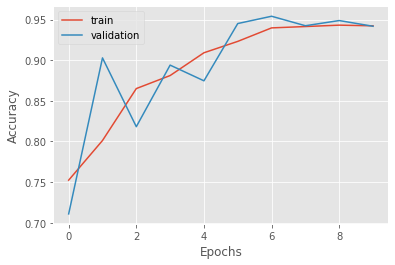

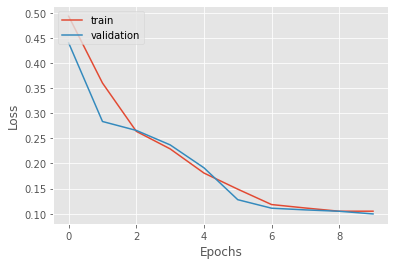

In [62]:
trainingLoss(history)

# Model experiment 6 evaluation

In [30]:
def evaluate_all(model_path, input_data, y_test):
    classifier = load_model(model_path)
    # y_pred returns probability of detached and overcontact 
    # for example [1.4059671e-04, 9.9985933e-01], 
    # means detached with prob. 0.0001405  and overcontact with prob 0.998
    y_pred = classifier.predict(input_data)
    # print(y_pred)
    
    # for example [1.4059671e-04, 9.9985933e-01] -> [0, 1], it is marked as detached 
    y_pred2 = np.where(y_pred > 0.5, 1, 0)
    
    # test data [0,1,...] is converted to categorical [[0,1],[1,0]]
    target_test = np.array(y_test)
    target_test = np_utils.to_categorical(target_test, 2)
    
    # confusion matrix -old 
    # cm = confusion_matrix(target_test.argmax(axis=1), y_pred2.argmax(axis=1))
    # print("Confusion matrix: \n" + str(cm))
    
    # confusion matrix - nice print 
    matrix=skplt.metrics.plot_confusion_matrix(target_test.argmax(axis=1), y_pred2.argmax(axis=1))
    matrix.xaxis.set_ticklabels(['single spotty', 'overcontact + detached'])
    matrix.yaxis.set_ticklabels(['single spotty', 'overcontact'])
    matrix
    
    target_names= ['single spotty', 'overcontact']
    print("Classification report: \n" + classification_report(target_test.argmax(axis=1), y_pred2.argmax(axis=1),target_names=target_names))

    # from categorical [0, 1] -> 1
    y_true = target_test.argmax(axis=1)
    
    skplt.metrics.plot_roc(y_true, y_pred)
    plt.savefig('roc_auc.png')
    plt.show()
    
    input_data = np.array(input_data)
    
    
    limit_plot=0
    for j in range(len(y_pred2)): 
        if (y_pred2[j].argmax(axis=0) == 1) and (target_test[j].argmax(axis=0) == 0):
            if input_data.ndim == 4:
                plt.plot(input_data[0][j],label = str(y_test.iloc[[j]].index[0]) + ", " +str(y_test.iloc[[j]].values[0]))
                fig1 = plt.figure(1)
                fig1.text(0.45, 0.9, "single spotty 0", ha="center", va="bottom", color="green")
                fig1.text(0.53, 0.9, "/", ha="center", va="bottom",  color="black")
                fig1.text(0.62, 0.9, "overcontact 1", ha="center", va="bottom",  color="red")
                limit_plot=limit_plot+1
            else:
                plt.plot(input_data[j],label = str(y_test.iloc[[j]].index[0]) + ", " +str(y_test.iloc[[j]].values[0]))
                fig1 = plt.figure(1)
                fig1.text(0.45, 0.9, "single spotty 0", ha="center", va="bottom" ,color="green")
                fig1.text(0.53, 0.9, "/", ha="center", va="bottom",  color="black")
                fig1.text(0.62,0.9, "overcontact 1", ha="center", va="bottom",  color="red")
                limit_plot=limit_plot+1
            if limit_plot == 2:
                break 

    
    plt.legend(loc='upper right')       
    plt.savefig('image.png')
    plt.show()     


    limit_plot2=0
    for j in range(len(y_pred2)): 
        if (y_pred2[j].argmax(axis=0) == 0) and (target_test[j].argmax(axis=0) == 1):
            if input_data.ndim == 4:
                plt.plot(input_data[0][j],label = str(y_test.iloc[[j]].index[0]) + ", " +str(y_test.iloc[[j]].values[0]))
                fig1 = plt.figure(1)
                fig1.text(0.45, 0.9, "single spotty 0", ha="center", va="bottom", color="red")
                fig1.text(0.53, 0.9, "/", ha="center", va="bottom",  color="black")
                fig1.text(0.62, 0.9, "overcontact 1", ha="center", va="bottom",  color="green")
                limit_plot2=limit_plot2+1
                
            else:
                plt.plot(input_data[j],label = str(y_test.iloc[[j]].index[0]) + ", " +str(y_test.iloc[[j]].values[0]))
                fig1 = plt.figure(1)
                fig1.text(0.45, 0.9, "single spotty 0", ha="center", va="bottom", color="red")
                fig1.text(0.53, 0.9, "/", ha="center", va="bottom",  color="black")
                fig1.text(0.62, 0.9, "overcontact 1", ha="center", va="bottom",  color="green")
                limit_plot2=limit_plot2+1
            if limit_plot2 == 2:
                break 
    
    plt.legend(loc='upper right')       
    plt.savefig('image2.png')
    plt.show()

(26855,)
(26855, 400, 1)
Classification report: 
              precision    recall  f1-score   support

           0       0.79      0.98      0.88      6915
           1       0.99      0.91      0.95     19940

    accuracy                           0.93     26855
   macro avg       0.89      0.94      0.91     26855
weighted avg       0.94      0.93      0.93     26855



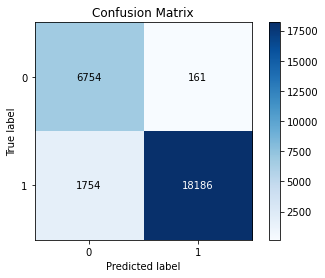

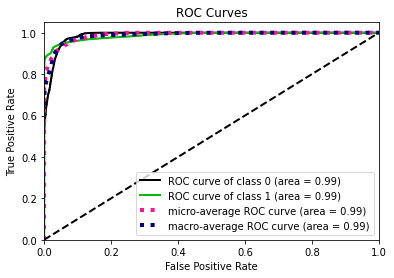

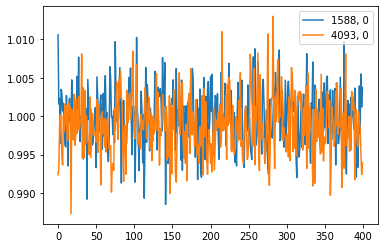

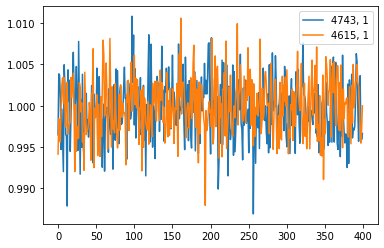

In [31]:
processed_test_data= np.concatenate((
 X_test_with_arrays_noise[0][0],
 X_test_with_arrays_noise[1][0],
 X_test_with_arrays_noise[2][0],
 X_test_with_arrays_noise[3][0],
 X_test_with_arrays_noise[4][0]))

y_test_mixed = pd.concat([y_test,
                            y_test, 
                            y_test, 
                            y_test,
                            y_test]) 
print(y_test_mixed.shape)
print(processed_test_data.shape)

evaluate_all('model_experiment_6.hdf5', processed_test_data, y_test_mixed)